In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from gradio_demo.model.utils import output_conv_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is: {device}')


/teamspace/studios/this_studio/ml-deploy/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current device is: cuda


Loading the dataset
---

In [2]:
dataset = load_dataset("Xenova/quickdraw-small")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)

In [3]:
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['valid']
train_dataset = train_dataset.shard(num_shards=4, index=0)
names = train_dataset.features['label'].names
n_classes = len(names)
print(f'size of trainset: {len(train_dataset)}, testset: {len(test_dataset)}')

size of trainset: 1125000, testset: 250000


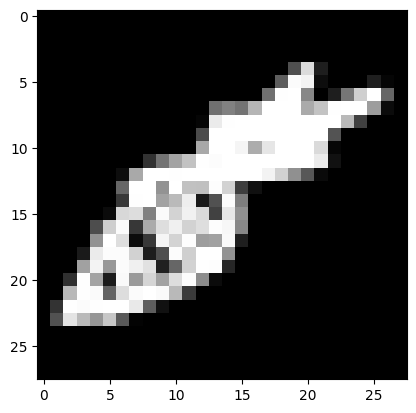

In [4]:
import json

with open('labels.json', 'w') as f:
    json.dump(names, f)

def id_to_class(idx):
    return names[idx]

# visualizing an example 
idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]['image'], test_dataset[idx]['label']
img = img[0].squeeze(dim=0)
plt.imshow(img, cmap='gray')

Model architechture
---

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is: {device}')

class CNN(nn.Module):
    def __init__(self, n_filters, hidden_dim, n_layers, n_classes):
        super().__init__()
        conv_kernel_size = 5
        maxpool_kernel_size = 2 
        self.conv1 = nn.Conv2d(1, n_filters, conv_kernel_size)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(maxpool_kernel_size)
        self.conv2 = nn.Conv2d(n_filters, 2*n_filters, conv_kernel_size)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(maxpool_kernel_size)
        self.input_dim = output_conv_size(img.shape[0], img.shape[1],conv_kernel_size=conv_kernel_size,maxpool_kernel_size=maxpool_kernel_size,n_filters=n_filters)#960 
        self.flatten = nn.Flatten()
        self.inp_layer = nn.Linear(self.input_dim, hidden_dim)
        self.classifier = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(p=0.3)
            ) for i in range(n_layers)
        ])
        self.out_layer = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.inp_layer(torch.flatten(x, start_dim=1))
        for layer in self.classifier:
            x = layer(x)
        x = self.out_layer(x)
        return x

Current device is: cuda


In [6]:
params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2,
    'n_classes': n_classes
}
model = CNN(**params).to(device)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 197385


In [ ]:
# hyperparameters
lr = 0.001
batch_size = 128
n_epochs = 5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4), DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

Training loop
---

In [8]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs, device):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'].to(device), batch['label'].to(device)
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'].to(device), batch['label'].to(device)
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [9]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs,device)

 31%|███       | 2694/8790 [00:46<01:45, 57.75it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), 'weights/cnn.pth')